In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math


In [2]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

## get data 

In [240]:
ger_train_path = "/home/adam/play/translate_data/train.de"
eng_train_path = "/home/adam/play/translate_data/train.en"

ger_train_raw = open(ger_train_path, "r").readlines()
eng_train_raw = open(eng_train_path, "r").readlines()

# just to help my poor laptop
ger_train_raw = ger_train_raw[:10000]
eng_train_raw = eng_train_raw[:10000]

In [241]:
print(len(ger_train))
print(len(eng_train))

10000
10000


In [242]:
### tokenize 
tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]) # do i need to account for the weird #AT things??
tokenizer.train(files=[ger_train_path, eng_train_path,], trainer=trainer)
tokenizer.enable_padding()
# tokenizer.train_from_iterator(iter(ger_train + eng_train), trainer=trainer)


In [243]:
ger_train = tokenizer.encode_batch(ger_train_raw)
eng_train = tokenizer.encode_batch(eng_train_raw)

In [244]:
ger_train = torch.tensor([t.ids for t in ger_train])
eng_train = torch.tensor([t.ids for t in eng_train])

In [245]:
ger_train.shape

torch.Size([10000, 258])

## define model

In [139]:
def create_mask(src, targ, pad_token):
    # NOTE: not fully confident in the unsqueeze - i think we get the extra-dimension so the masked_fill can broadcast it 
    # we want to broadcast for the padding mask because it's the same on both axes (unlike with the causal mask) 
    src_pad_mask = (src != pad_token).unsqueeze(1) # (B, 1, context_size)
    targ_pad_mask = (targ != pad_token).unsqueeze(1)
    full_mask = torch.ones((targ.shape[1], targ.shape[1])).type(torch.int)
    causal_atten_mask = torch.tril(full_mask) # (context_size, context_size)

    return src_pad_mask, targ_pad_mask & causal_atten_mask

def calculate_loss(logits, labels, pad_idx):
    B, T, V = logits.shape # (batch, context_size, vocab_size)
    # cross entropy expects list of indices and logits requiring reshape
    return F.cross_entropy(logits.reshape(B * T, V), labels.reshape(B * T), ignore_index=pad_idx)

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.n_embed = n_embed
        self.n_heads = n_heads
        assert(n_embed % n_heads == 0) # check dims work
        self.head_size = n_embed // n_heads
        self.dropout = dropout

        self.wk = nn.Linear(n_embed, n_embed, bias=False)
        self.wq = nn.Linear(n_embed, n_embed, bias=False)
        self.wv = nn.Linear(n_embed, n_embed, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(n_embed, n_embed)
        self.attn_store = None

    def forward(self, x, features, mask):
        B, T, C = features.shape # (batch, context_size, n_embed)

        # create k
        # NOTE: make sure the maths works here
        k = self.wk(features) # (B, context_size, n_embed) @ (n_embed, n_embed) ---> (B, context_size, n_embed)
        # split per head
        k = k.view(B, T, self.n_heads, self.head_size)  # (B, context_size, n_embed) --> (B, context_size, n_heads, head_size)
        # switch context size and n_heads dim so we can batch matmul over B and n_heads
        k = k.transpose(1,2) # (B, context_size, n_heads, head_size) --> (B, n_heads, context_size, head_size)
        
        # create q 
        q = self.wq(x)
        q = q.view(q.shape[0], q.shape[1], self.n_heads, self.head_size) # q can be a different shape to k and v so need to use its own shape
        q = q.transpose(1,2)

        # create v 
        v = self.wv(features)
        v = v.view(B, T, self.n_heads, self.head_size)
        v = v.transpose(1, 2)

        attn = q @ k.transpose(-2, -1) # (B, n_heads, context_size, head_size) @ (B, n_heads, head_size, context_size) --> (B, n_heads, context_size, context_size)
        attn = attn / (self.n_embed ** 0.5) # divide by squareroot of n_embed to decrease magnitude
        
        # if this is a masked attention layer (causal?) mask out all tokens before the cur pos, otherwise just mask out padding 
        attn = attn.masked_fill(mask.unsqueeze(1) == 0, float("-inf")) # TODO: check that the dimensions here work
        self.attn_store = attn
        attn = self.dropout(F.softmax(attn, dim=-1))
        
        # generate the v matrix and use the attn matrix to pluck out relevant info on a per head basis
        out = attn @ v # (B, n_heads, context_size, context_size) @ (B, n_heads, context_size, head_size) --> (B, n_heads, context_size, head_size)
        # remove per-head dimension and use final linear projection
        out = out.view(out.shape[0], -1, self.n_embed) # (B, n_heads, context_size, head_size) --> (B, context_size, n_embed)
        return self.proj(out)

class FeedForward(nn.Module):
    def __init__(self, n_embed, dropout):
        super().__init__()
        self.ffw = nn.Sequential(
            nn.Linear(n_embed, 4* n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ffw(x) # (B, context_size, n_embed) @ (n_embed, 4*n_embed) @ (4*n_embed, n_embed) --> (B, context_size, n_embed)

class EncoderBlock(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.ffw = FeedForward(n_embed, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, inputs):
        x, mask = inputs
        out = self.attention(x, x, mask)
        out = self.ln1(out) + x
        out = self.ffw(out)
        out = self.ln2(out) + x
        return (out, mask)

class DecoderBlock(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.masked_attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.ffw = FeedForward(n_embed, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)

    def forward(self, inputs):
        # unpack inputs
        x, features, src_mask, targ_mask = inputs
        out = self.masked_attention(x, x, targ_mask)
        out = self.ln1(out) + x
        out = self.attention(out, features, src_mask)
        out = self.ln2(out) + x
        out = self.ffw(out)
        out = self.ln3(out) + x
        return (out, features, src_mask, targ_mask)

class PositionalEmbedding(nn.Module):
    def __init__(self, n_embed, context_size):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        posem = torch.zeros((context_size+1, n_embed))
        for pos in range(context_size+1):
            for i in range(n_embed, 2):
                posem[pos, i] = math.sin(pos/(10000**(2*i/n_embed)))
                posem[pos, i+1] = math.cos(pos/(10000**(2*(i+1)/n_embed)))
        posem.unsqueeze(0)
        self.register_buffer("posem", posem)

    def forward(self, x):
        return x + self.posem[torch.arange(x.shape[1]),:]

class Generator(nn.Module):
    def __init__(self, n_embed, output_vocab_size):
        super().__init__()
        self.proj = nn.Linear(n_embed, output_vocab_size)

    def forward(self, x):
        return self.proj(x)

class EncoderDecoderTransformer(nn.Module):
    def __init__(self, n_heads, n_embed, dropout, n_blocks, context_size, input_vocab_size, output_vocab_size):
        super().__init__()
        self.input_embedding = nn.Embedding(input_vocab_size, n_embed)
        self.positional_embedding = PositionalEmbedding(n_embed, context_size)
        self.encoders = nn.Sequential(*[EncoderBlock(n_heads, n_embed, dropout) for _ in range(n_blocks)])
        self.decoders = nn.Sequential(*[DecoderBlock(n_heads, n_embed, dropout) for _ in range(n_blocks)])
        self.output = Generator(n_embed, output_vocab_size)
    
    def encode(self, src, src_mask):
        x = self.input_embedding(src)
        x = self.positional_embedding(x)
        x = self.encoders((x, src_mask))[0]
        return x

    def decode(self, targ, features, src_mask, targ_mask):
        x = self.input_embedding(targ)
        x = self.positional_embedding(x)
        x = self.decoders((x , features, src_mask, targ_mask))[0]
        return self.output(x)
    
    def forward(self, src, targ, src_mask, targ_mask):
        x = self.encode(src, src_mask)
        out = self.decode(targ, x, src_mask, targ_mask)
        return out

# very scratch test forward pass

In [7]:
# TODO: work out how to handle extracting k and v from multiple heads in final encoder block?? very possibly I should just rewrite in the kombo-head pattern 

model = EncoderDecoderTransformer(
    n_heads=3, n_embed=6, dropout=0.2, n_blocks=5, context_size=12, input_vocab_size=12, output_vocab_size=12
)

# x = torch.arange(11)
# y = torch.tensor([[0]])
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])
start_symbol = torch.zeros(target.shape[0], 1).fill_(11).type_as(target)
y = torch.cat((start_symbol, target[:,:-1]), dim=1)
src_mask, targ_mask = create_mask(src, target, 10)
out = model(src, y, src_mask, targ_mask)

In [298]:
out.shape

torch.Size([2, 12, 12])

# test on synthetic data

In [182]:
def generate_fake_data(vocab_size, batch_size):
    data = torch.randint(2, vocab_size+2, size=(batch_size, 10))
    src = data.requires_grad_(False).clone().detach()
    target = data.requires_grad_(False).clone().detach()
    target = torch.cat((torch.zeros(target.shape[0], 1), target), dim=1)
    target = torch.cat((target, torch.ones(target.shape[0], 1)), dim=1)
    targ = target[:,:-1].type(torch.long)
    labels = target[:,1:].type(torch.long)
    src_mask, targ_mask = create_mask(src, targ, 99)
    return [src, targ, labels, src_mask, targ_mask]

In [190]:
src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 2)

In [191]:
print(src[0].shape, src[0])
print(targ[0].shape, targ[0])
print(labels[0].shape, labels[0])


torch.Size([10]) tensor([ 9,  9,  6,  2, 10,  5,  6,  8,  3,  4])
torch.Size([11]) tensor([ 0,  9,  9,  6,  2, 10,  5,  6,  8,  3,  4])
torch.Size([11]) tensor([ 9,  9,  6,  2, 10,  5,  6,  8,  3,  4,  1])


In [192]:
## create model
model = EncoderDecoderTransformer(
    n_heads=4, n_embed=64, dropout=0.2, n_blocks=6, context_size=20, input_vocab_size=12, output_vocab_size=12
)

In [193]:
## train model

optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

losses = []

for step in range(500):
    src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 64)
    # forward pass
    logits = model(src, targ, src_mask, targ_mask)
    loss = calculate_loss(logits, labels, 99)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 100 == 0:
        print(f"{step=} {loss.item()=}")

step=0 loss.item()=3.368835687637329
step=100 loss.item()=0.07858247309923172
step=200 loss.item()=0.002147453837096691
step=300 loss.item()=0.00025999455829150975
step=400 loss.item()=0.0013830573298037052


In [196]:
print(labels[3].shape, logits[3].shape)
print(labels[3])
# print(logits[1])
print(torch.argmax(logits[3], dim=1))
# plt.imshow(model.decoders[0].masked_attention.attn_store[0,3].detach().numpy())
print(src[3])

torch.Size([11]) torch.Size([11, 12])
tensor([ 2,  8,  6,  2, 11,  3,  9,  5,  7,  8,  1])
tensor([ 2,  8,  6,  2, 11,  3,  9,  5,  7,  8,  1])
tensor([ 2,  8,  6,  2, 11,  3,  9,  5,  7,  8])


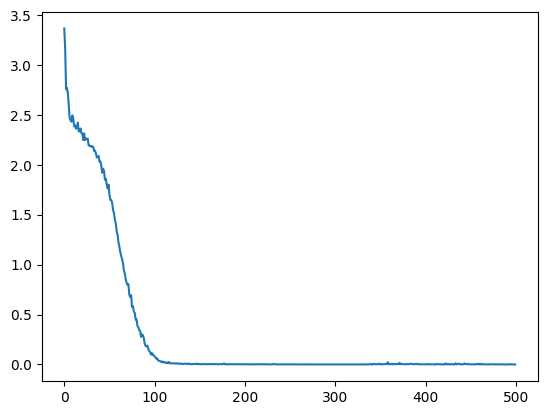

In [195]:
plt.plot(losses)

In [199]:
def greedy_decoding(model, src, context_size):
    targ = torch.zeros(1,src.shape[1] + 1).type(torch.int)
    src_mask, _ = create_mask(src, src, 99)
    features = model.encode(src, src_mask)
    for i in range(context_size):
        src_mask, targ_mask = create_mask(src, targ, 99)
        proj = model.decode(targ, features, src_mask, targ_mask)
        tok = torch.argmax(proj[0,i,:], keepdims=True)
        tok = tok.unsqueeze(0)
        if tok.item() == 1:
            return targ, proj
        # cur_targ = torch.cat([cur_targ, tok], dim=1).type(torch.int)
        targ[0, i+1] = tok
    return targ, proj

src = torch.randint(2, 12, size=(1, 10))

targ, proj = greedy_decoding(model, src, 20)
print(src)
print(targ[0,1:])
# print(proj)

tensor([[ 2,  7, 10,  4, 11, 10,  9, 11, 10,  2]])
tensor([ 2,  7, 10,  4, 11, 10,  9, 11, 10,  2], dtype=torch.int32)


In [133]:
# ans = torch.max(proj[0,0],0)
# ans
torch.zeros((1,1)).type(torch.int)

tensor([[0]], dtype=torch.int32)

# test training on real data

In [14]:
import torchtext.datasets
from torch.utils.data import DataLoader

train_data = torchtext.datasets.Multi30k(split='train', language_pair=('de', 'en'))
val_data = torchtext.datasets.Multi30k(split='valid', language_pair=('de', 'en'))

In [15]:
import en_core_web_sm
import de_core_news_sm

en_tokenizer = en_core_web_sm.load()
de_tokenizer = de_core_news_sm.load()

In [17]:
from collections import Counter

def get_unique_tokens(text, tokenizer):
    cnt = Counter()
    for doc in tokenizer.pipe(text):
        doc_tokens = [tok.text.strip() for tok in doc if len(tok.text) > 0]
        cnt.update(doc_tokens)
    return [tok[0] for tok in cnt.most_common(10000)]

src_text, targ_text = list(zip(*train_data))

de_toks = get_unique_tokens(src_text, de_tokenizer)
en_toks = get_unique_tokens(targ_text, en_tokenizer)


/home/adam/dev/translate-gpt/.env/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [18]:
# special token indices
UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

UNK = '<unk>' # Unknown
PAD = '<pad>' # Padding
SOS = '<sos>' # Start of sentence
EOS = '<eos>' # End of sentence

SPECIAL_TOKENS = [UNK, PAD, SOS, EOS]

class Vocab:
    def __init__(self, tokenizer, tokens):
        self.tokenizer = tokenizer
        self.tokens = SPECIAL_TOKENS + tokens
        self.token_idxs = {self.tokens[i]: i for i in range(len(tokens))}

    def __call__(self, text):
        return [self.numerify(tok.text.strip()) for tok in self.tokenizer(text)]
    
    def numerify(self, tok):
        if tok not in self.token_idxs:
            return UNK_IDX
        return self.token_idxs[tok]

de_vocab = Vocab(de_tokenizer, de_toks)
en_vocab = Vocab(en_tokenizer, en_toks)

In [201]:
from torch.nn.utils.rnn import pad_sequence

def make_dataloader(dataset, batch_size, context_size, device): 
    def collate_fn(batch):
        srcs = []
        targs = []
        for i, (src_sentence, targ_sentence) in enumerate(batch):
            src = de_vocab(src_sentence)
            targ = [SOS_IDX] + en_vocab(targ_sentence) + [EOS_IDX]
    
            srcs.append(torch.tensor(src))
            targs.append(torch.tensor(targ))
    
        src_batch = pad_sequence(srcs, padding_value=PAD_IDX, batch_first=True)
        targ_batch = pad_sequence(targs, padding_value=PAD_IDX, batch_first=True)
    
        # decoder wants target starting with SOS
        target_batch = targ_batch[:, :-1]
        # however when calculating loss we are only interested in tokens after SOS and ending with EOS
        label_batch = targ_batch[:, 1:]
        src_mask, targ_mask = create_mask(src_batch, target_batch, PAD_IDX) # TODO: understand what the hell happens with different context lengths
    
        all_batches = [src_batch, target_batch, label_batch, src_mask, targ_mask]
        return [b.to(device) for b in all_batches]

    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

train_dataloader = make_dataloader(train_data, 32, 40, "cpu")
val_dataloader = make_dataloader(val_data, 100, 40, "cpu")

In [203]:
from tqdm import tqdm

model = EncoderDecoderTransformer(
    n_heads=8, n_embed=128, dropout=0.2, n_blocks=6, context_size=44, input_vocab_size=len(de_vocab.tokens), output_vocab_size=len(en_vocab.tokens)
)

optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

with tqdm(train_dataloader, unit="batch") as iter:
    losses = []
    for step, (src, targ, labels, src_mask, targ_mask) in enumerate(iter):
        # forward pass
        logits = model(src, targ, src_mask, targ_mask)
        loss = calculate_loss(logits, labels, PAD_IDX)
        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
        if step % 10 == 0:
            print(f"{loss.item()=}")
    
    

1batch [00:00,  1.86batch/s]

loss.item()=10.488906860351562


11batch [00:05,  1.90batch/s]

loss.item()=5.766294956207275


21batch [00:10,  1.98batch/s]

loss.item()=5.211877822875977


31batch [00:16,  1.98batch/s]

loss.item()=5.110589027404785


41batch [00:21,  1.94batch/s]

loss.item()=5.434295654296875


51batch [00:26,  1.83batch/s]

loss.item()=5.336674690246582


61batch [00:31,  1.83batch/s]

loss.item()=5.0815253257751465


71batch [00:37,  1.83batch/s]

loss.item()=4.955556392669678


81batch [00:42,  1.94batch/s]

loss.item()=4.749855995178223


91batch [00:47,  1.91batch/s]

loss.item()=4.6790032386779785


101batch [00:52,  1.95batch/s]

loss.item()=4.954250812530518


111batch [00:58,  1.96batch/s]

loss.item()=4.744067192077637


121batch [01:03,  1.96batch/s]

loss.item()=4.476064205169678


131batch [01:08,  1.89batch/s]

loss.item()=4.632311820983887


141batch [01:13,  1.98batch/s]

loss.item()=4.026826858520508


151batch [01:18,  1.99batch/s]

loss.item()=3.9137227535247803


161batch [01:23,  1.98batch/s]

loss.item()=5.385863304138184


171batch [01:28,  1.95batch/s]

loss.item()=4.399586200714111


181batch [01:33,  1.96batch/s]

loss.item()=4.283005714416504


191batch [01:38,  2.00batch/s]

loss.item()=4.398786544799805


201batch [01:43,  1.91batch/s]

loss.item()=4.389658451080322


211batch [01:49,  1.94batch/s]

loss.item()=4.272395610809326


221batch [01:54,  2.00batch/s]

loss.item()=4.184638023376465


231batch [01:59,  1.86batch/s]

loss.item()=4.027780055999756


241batch [02:05,  1.60batch/s]

loss.item()=3.8719496726989746


251batch [02:11,  1.69batch/s]

loss.item()=4.18194580078125


261batch [02:17,  1.65batch/s]

loss.item()=4.22096586227417


271batch [02:23,  1.71batch/s]

loss.item()=3.9324278831481934


281batch [02:29,  1.67batch/s]

loss.item()=4.0414652824401855


291batch [02:35,  1.63batch/s]

loss.item()=3.929612159729004


301batch [02:41,  1.65batch/s]

loss.item()=3.781160354614258


311batch [02:47,  1.70batch/s]

loss.item()=3.7743353843688965


321batch [02:53,  1.68batch/s]

loss.item()=4.184779644012451


331batch [02:59,  1.66batch/s]

loss.item()=3.86842679977417


341batch [03:05,  1.64batch/s]

loss.item()=3.4732236862182617


351batch [03:11,  1.57batch/s]

loss.item()=4.001214981079102


361batch [03:17,  1.74batch/s]

loss.item()=4.352128028869629


371batch [03:23,  1.67batch/s]

loss.item()=3.888756275177002


381batch [03:29,  1.78batch/s]

loss.item()=3.7395875453948975


391batch [03:35,  1.60batch/s]

loss.item()=3.8262805938720703


401batch [03:41,  1.65batch/s]

loss.item()=3.853325128555298


411batch [03:47,  1.66batch/s]

loss.item()=3.9283413887023926


421batch [03:53,  1.63batch/s]

loss.item()=3.604412794113159


431batch [03:59,  1.69batch/s]

loss.item()=3.3804831504821777


441batch [04:05,  1.70batch/s]

loss.item()=3.660642385482788


451batch [04:11,  1.68batch/s]

loss.item()=3.7757365703582764


461batch [04:17,  1.66batch/s]

loss.item()=3.71240496635437


471batch [04:23,  1.73batch/s]

loss.item()=3.9330320358276367


481batch [04:29,  1.68batch/s]

loss.item()=4.090284824371338


491batch [04:35,  1.68batch/s]

loss.item()=3.800464391708374


501batch [04:41,  1.62batch/s]

loss.item()=4.087432384490967


511batch [04:47,  1.63batch/s]

loss.item()=3.7930638790130615


521batch [04:54,  1.53batch/s]

loss.item()=3.7781989574432373


531batch [05:00,  1.64batch/s]

loss.item()=3.721280813217163


541batch [05:06,  1.43batch/s]

loss.item()=3.839611291885376


551batch [05:12,  1.82batch/s]

loss.item()=3.796506881713867


561batch [05:17,  1.85batch/s]

loss.item()=3.588045597076416


571batch [05:23,  1.93batch/s]

loss.item()=3.5810084342956543


581batch [05:28,  1.96batch/s]

loss.item()=3.405695915222168


591batch [05:33,  1.94batch/s]

loss.item()=3.469553232192993


601batch [05:38,  1.90batch/s]

loss.item()=3.5906829833984375


611batch [05:44,  1.85batch/s]

loss.item()=3.8222100734710693


621batch [05:49,  1.86batch/s]

loss.item()=3.8393349647521973


631batch [05:54,  1.86batch/s]

loss.item()=3.7020654678344727


641batch [06:00,  1.68batch/s]

loss.item()=3.4514546394348145


651batch [06:06,  1.61batch/s]

loss.item()=3.570735454559326


661batch [06:13,  1.59batch/s]

loss.item()=3.546398878097534


671batch [06:19,  1.56batch/s]

loss.item()=3.4519433975219727


681batch [06:25,  1.65batch/s]

loss.item()=3.3525099754333496


691batch [06:31,  1.50batch/s]

loss.item()=3.8046820163726807


701batch [06:38,  1.63batch/s]

loss.item()=3.207732677459717


711batch [06:44,  1.64batch/s]

loss.item()=3.8605751991271973


721batch [06:50,  1.66batch/s]

loss.item()=3.2472879886627197


731batch [06:56,  1.64batch/s]

loss.item()=3.635829448699951


741batch [07:02,  1.58batch/s]

loss.item()=3.8200509548187256


751batch [07:08,  1.61batch/s]

loss.item()=3.706303596496582


761batch [07:15,  1.63batch/s]

loss.item()=3.609208106994629


771batch [07:21,  1.55batch/s]

loss.item()=4.042797565460205


781batch [07:27,  1.62batch/s]

loss.item()=3.8586483001708984


791batch [07:34,  1.58batch/s]

loss.item()=3.8689069747924805


801batch [07:40,  1.53batch/s]

loss.item()=3.729856014251709


811batch [07:46,  1.62batch/s]

loss.item()=3.9365382194519043


821batch [07:53,  1.57batch/s]

loss.item()=3.5630874633789062


831batch [07:59,  1.64batch/s]

loss.item()=3.761065721511841


841batch [08:05,  1.55batch/s]

loss.item()=4.026031017303467


851batch [08:12,  1.54batch/s]

loss.item()=3.7375261783599854


861batch [08:18,  1.64batch/s]

loss.item()=3.321027994155884


871batch [08:24,  1.52batch/s]

loss.item()=4.109722137451172


881batch [08:31,  1.55batch/s]

loss.item()=3.659573554992676


891batch [08:37,  1.59batch/s]

loss.item()=3.5265257358551025


901batch [08:43,  1.65batch/s]

loss.item()=3.287187337875366


907batch [08:47,  1.72batch/s]


In [186]:
losses

[9.210733413696289,
 9.210726737976074,
 9.21072769165039,
 9.210715293884277,
 9.210716247558594,
 9.210707664489746,
 9.210700035095215,
 9.21069622039795,
 9.210679054260254,
 9.210673332214355,
 9.210649490356445,
 9.2106294631958,
 9.210603713989258,
 9.210601806640625,
 9.210576057434082,
 9.210556983947754,
 9.210526466369629,
 9.210470199584961,
 9.21037769317627,
 9.210357666015625,
 9.210260391235352,
 9.210247039794922,
 9.210076332092285,
 9.2099609375,
 9.209695816040039,
 9.209587097167969,
 9.209501266479492,
 9.20931625366211,
 9.208842277526855,
 9.208385467529297,
 9.207955360412598,
 9.207120895385742,
 9.206398963928223,
 9.205703735351562,
 9.204448699951172,
 9.20336627960205,
 9.202404975891113,
 9.199590682983398,
 9.197884559631348,
 9.194610595703125,
 9.193553924560547,
 9.187616348266602,
 9.184483528137207,
 9.179563522338867,
 9.174766540527344,
 9.166749954223633,
 9.159613609313965,
 9.157155990600586,
 9.145181655883789,
 9.141651153564453,
 9.137707710

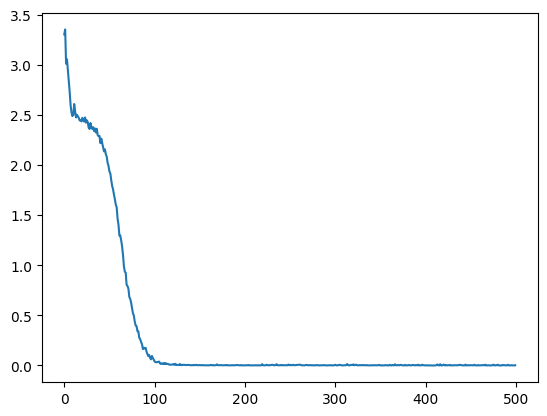

In [28]:
import matplotlib.pyplot as plt

plt.plot(losses)